In [1]:
import os
# emulate multiple devices in a CPU environment
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torchvision import datasets
from torchvision.transforms import v2

from functools import partial
import orbax.checkpoint as ocp
import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec, NamedSharding
import optax
from flax import nnx

In [10]:
conv = nnx.Conv(in_features=2, out_features=16, kernel_size=(3, 3), rngs=nnx.Rngs(0))

In [11]:
(conv.kernel.value.shape, # (kernel, in, out)
	conv.bias.value.shape)

((3, 3, 2, 16), (16,))

In [12]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [4]:
transform = v2.Compose([
  v2.PILToTensor(),
  v2.ToDtype(torch.float32, scale=True),
])

In [5]:
cifar10 = datasets.CIFAR10(
  'data', train=True, transform=transform, download=False)

In [6]:
imgs = np.stack([img for img, _ in cifar10], axis=3)
imgs.shape

(3, 32, 32, 50000)

In [7]:
cifar10_mean = np.mean(imgs, axis=(1, 2, 3))
cifar10_std = np.std(imgs, axis=(1, 2, 3))

In [8]:
class Cifar2(torch.utils.data.Dataset):
	def __init__(self, root, train=True, download=False, transform=None):
		self.cifar10 = datasets.CIFAR10(
			root=root, train=train, download=download, transform=transform)
		self.indices = np.nonzero(np.isin(self.cifar10.targets, [0, 2]))[0]

	def __len__(self):
		return len(self.indices)

	def __getitem__(self, idx):
		original_idx = self.indices[idx]
		img, label = self.cifar10[original_idx]

		label = {2: 1}.get(label, label) # 0 to 0, 2 to 1
		return img, label

In [9]:
transform = v2.Compose([
  v2.PILToTensor(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(cifar10_mean, cifar10_std),
  v2.Lambda(lambda x: torch.moveaxis(x, 0, 2))# (H, W, C)
])

In [10]:
cifar2 = Cifar2(root='data', transform=transform)

In [11]:
def jnp_collate(batch):
  return jax.tree.map(jnp.asarray, torch.utils.data.default_collate(batch))

In [51]:
cifar2_loader = torch.utils.data.DataLoader(
  cifar2, batch_size=1, shuffle=True, collate_fn=jnp_collate)

In [88]:
conv = nnx.Conv(in_features=3, out_features=16, 
                kernel_size=(3, 3), padding='VALID', rngs=nnx.Rngs(0))

In [89]:
cifar2_loader_iter = iter(cifar2_loader)
img, _ = next(cifar2_loader_iter)

output = conv(img)
img.shape, output.shape

((1, 32, 32, 3), (1, 30, 30, 16))

In [90]:
img.mean(-1).shape

(1, 32, 32)

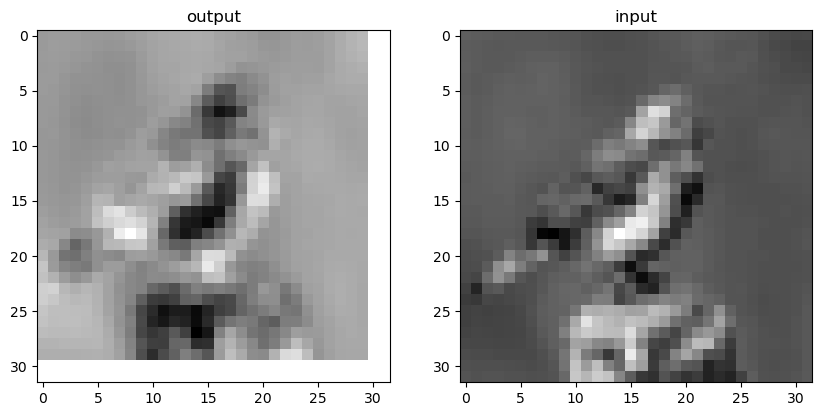

In [91]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)   
plt.title('output')   
plt.imshow(output[0][..., 0], cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img[0].mean(-1), cmap='gray')
plt.title('input')
plt.show()

In [155]:
conv = nnx.Conv(in_features=3, out_features=1, 
                kernel_size=(3, 3), padding='SAME', rngs=nnx.Rngs(0))

In [156]:
output = conv(img)
img.shape, output.shape

((1, 32, 32, 3), (1, 32, 32, 1))

In [157]:
conv.bias.value

Array([0.], dtype=float32)

In [184]:
conv.kernel.value = jnp.full(conv.kernel_shape, 1./9.)

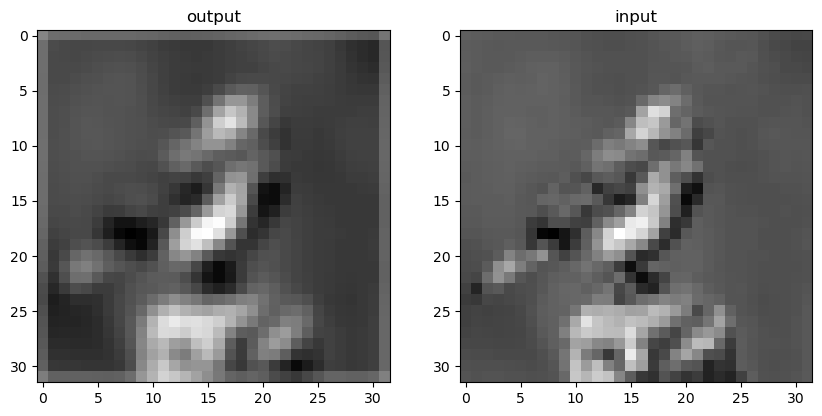

In [160]:
output = conv(img)

plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)   
plt.title('output')   
plt.imshow(output[0][..., 0], cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img[0].mean(-1), cmap='gray')
plt.title('input')
plt.show()

In [162]:
new_kernel = jnp.array([[-1.0, 0.0, 1.0],
                        [-1.0, 0.0, 1.0],
                        [-1.0, 0.0, 1.0]])

In [186]:
conv.kernel.value = jnp.broadcast_to(new_kernel[..., None, None], conv.kernel_shape)

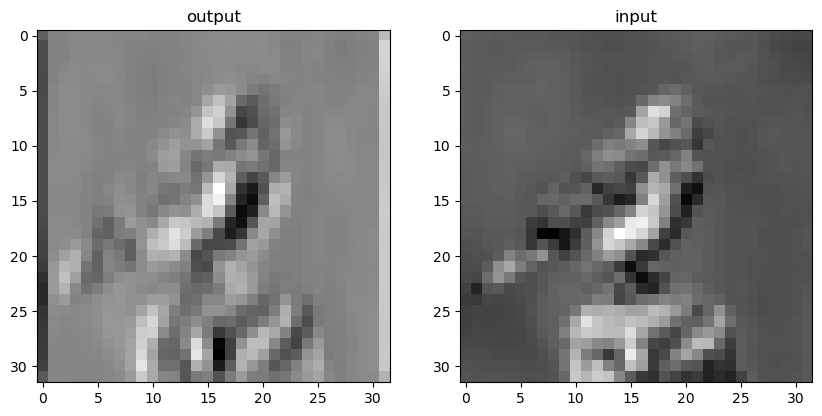

In [187]:
output = conv(img)

plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0][..., 0], cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img[0].mean(-1), cmap='gray')
plt.title('input')
plt.show()

In [198]:
output = nnx.max_pool(img, window_shape=(2, 2), strides=(2, 2))

In [199]:
img.shape, output.shape

((1, 32, 32, 3), (1, 16, 16, 3))

In [12]:
class Net(nnx.Module):
  def __init__(self, *, rngs: nnx.Rngs):
    self.conv1 = nnx.Conv(3, 16, kernel_size=(3, 3), rngs=rngs)
    self.conv2 = nnx.Conv(16, 8, kernel_size=(3, 3), rngs=rngs)
    self.max_pool = partial(nnx.max_pool, window_shape=(2, 2), strides=(2, 2))
    self.linear1 = nnx.Linear(8*8*8, 32, rngs=rngs)
    self.linear2 = nnx.Linear(32, 2, rngs=rngs)

  def __call__(self, x):
    x = self.max_pool(nnx.tanh(self.conv1(x)))
    x = self.max_pool(nnx.tanh(self.conv2(x)))
    x = x.reshape(x.shape[0], -1)  # flatten
    x = nnx.tanh(self.linear1(x))
    x = self.linear2(x)
    return x

In [87]:
model = Net(rngs=nnx.Rngs(0))

In [88]:
graphdef, params = nnx.split(model, nnx.Param)

In [204]:
num_params = [np.prod(x.shape) for x in jax.tree.leaves(params)]
np.sum(num_params), num_params

(18090, [16, 432, 8, 1152, 32, 16384, 2, 64])

In [205]:
model(img)

Array([[-0.29517338, -0.40224028]], dtype=float32)

In [14]:
@jax.jit
def train_step(state: nnx.TrainState, batch):
  imgs, labels = batch

  def loss_fn(params):
    model = nnx.merge(state.graphdef, params)
    logits = model(imgs)
    loss = optax.losses.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return state, loss, accuracy

In [15]:
@jax.jit
def val_step(state: nnx.TrainState, batch):
  imgs, labels = batch

  def loss_fn(params):
    model = nnx.merge(state.graphdef, params)
    logits = model(imgs)
    loss = optax.losses.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    return loss, logits

  loss, logits = loss_fn(state.params)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return loss, accuracy

In [18]:
state = nnx.TrainState.create(
  graphdef=graphdef,
  params=params,
  tx=optax.sgd(learning_rate=1e-2))

del graphdef, params

In [19]:
train_loader = torch.utils.data.DataLoader(
  cifar2, batch_size=64, shuffle=True, collate_fn=jnp_collate)

In [20]:
cifar2_val = Cifar2(root='data', train=False, transform=transform)

val_loader = torch.utils.data.DataLoader(
  cifar2_val, batch_size=64, shuffle=True, collate_fn=jnp_collate)

In [230]:
n_epochs = 100

metrics_log = {
  'train_loss': [], 'train_accuracy': [],
  'val_loss': [], 'val_accuracy': [],
}
epoch_log = {
		'train_loss': [], 'train_accuracy': [],
		'val_loss': [], 'val_accuracy': [],
}
for epoch in range(1, n_epochs + 1):
	for batch in train_loader:
		state, loss, accuracy = train_step(state, batch)
		epoch_log['train_loss'].append(loss)
		epoch_log['train_accuracy'].append(accuracy)
	
	if epoch % 5 == 0:
		for batch in val_loader:
			loss_v, accuracy_v = val_step(state, batch)
			epoch_log['val_loss'].append(loss_v)
			epoch_log['val_accuracy'].append(accuracy_v)

		for dataset in ('train', 'val'):
			metrics_log[f'{dataset}_loss'].append(
				jnp.array(epoch_log[f'{dataset}_loss']).mean())
			epoch_log[f'{dataset}_loss'] = []
			
			metrics_log[f'{dataset}_accuracy'].append(
				jnp.array(epoch_log[f'{dataset}_accuracy']).mean())
			epoch_log[f'{dataset}_accuracy'] = []

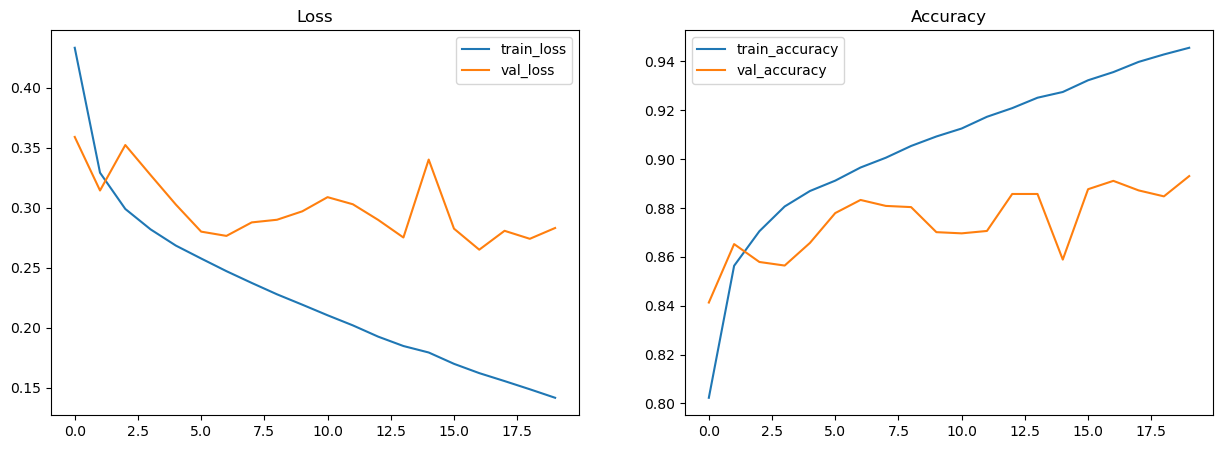

In [231]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'val'):
  ax1.plot(metrics_log[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_log[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

In [90]:
ckpt_dir = ocp.test_utils.erase_and_create_empty('/tmp/birds_vs_airplanes')

In [91]:
checkpointer = ocp.PyTreeCheckpointer()
checkpointer.save(ckpt_dir / 'params', state.params)

In [92]:
abstract_model = nnx.eval_shape(lambda: Net(rngs=nnx.Rngs(0)))
graphdef, abstract_params = nnx.split(abstract_model)

In [93]:
nnx.display(abstract_params)

In [94]:
params_restored = checkpointer.restore(ckpt_dir / 'params', abstract_params)

In [95]:
loaded_model = nnx.merge(graphdef, params_restored)

In [21]:
jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]

In [22]:
jax.experimental.mesh_utils.create_device_mesh((2,4))

array([[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2),
        CpuDevice(id=3)],
       [CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6),
        CpuDevice(id=7)]], dtype=object)

In [23]:
np.array(jax.devices()).reshape(2, 4)

array([[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2),
        CpuDevice(id=3)],
       [CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6),
        CpuDevice(id=7)]], dtype=object)

In [27]:
Mesh(devices=np.array(jax.devices()).reshape((2, 4)), axis_names=('x', 'y'))

Mesh(device_ids=array([[0, 1, 2, 3],
       [4, 5, 6, 7]]), axis_names=('x', 'y'), axis_types={Hidden: ('x', 'y')})

In [26]:
jax.make_mesh(axis_shapes=(2,4), axis_names=('x', 'y'))

Mesh(device_ids=array([[0, 1, 2, 3],
       [4, 5, 6, 7]]), axis_names=('x', 'y'), axis_types={Hidden: ('x', 'y')})

In [28]:
num_devices = jax.local_device_count()

mesh = jax.make_mesh(axis_shapes=(num_devices,), axis_names=('data',))

model_sharding = NamedSharding(mesh, PartitionSpec())
data_sharding = NamedSharding(mesh, PartitionSpec('data'))

In [31]:
model = Net(rngs=nnx.Rngs(0))

In [32]:
graphdef, params = nnx.split(model, nnx.Param)

In [33]:
state = nnx.TrainState.create(
  graphdef=graphdef,
  params=params,
  tx=optax.sgd(learning_rate=1e-2))

del graphdef, params

In [34]:
state = jax.device_put(state, model_sharding)

In [48]:
# replicate model params
jax.debug.visualize_array_sharding(state.params.linear1.kernel.value)

                   
                   
                   
                   
                   
CPU 0,1,2,3,4,5,6,7
                   
                   
                   
                   
                   

In [57]:
cifar2_loader = torch.utils.data.DataLoader(
  cifar2, batch_size=64, shuffle=True, collate_fn=jnp_collate)

cifar2_loader_iter = iter(cifar2_loader)
batch = next(cifar2_loader_iter)

In [58]:
batch = jax.device_put(batch, data_sharding)

In [60]:
# sharding/distributing data
jax.debug.visualize_array_sharding(batch[1])

  CPU 0    CPU 1    CPU 2    CPU 3    CPU 4    CPU 5    CPU 6    CPU 7  
                                                                        

In [49]:
n_epochs = 100

metrics_log = {
  'train_loss': [], 'train_accuracy': [],
  'val_loss': [], 'val_accuracy': [],
}
epoch_log = {
		'train_loss': [], 'train_accuracy': [],
		'val_loss': [], 'val_accuracy': [],
}
for epoch in range(1, n_epochs + 1):
	for batch in train_loader:
		# data sharding
		batch = jax.device_put(batch, data_sharding)
		state, loss, accuracy = train_step(state, batch)
		epoch_log['train_loss'].append(loss)
		epoch_log['train_accuracy'].append(accuracy)
	
	if epoch % 5 == 0:
		for batch in val_loader:
			loss_v, accuracy_v = val_step(state, batch)
			epoch_log['val_loss'].append(loss_v)
			epoch_log['val_accuracy'].append(accuracy_v)

		for dataset in ('train', 'val'):
			metrics_log[f'{dataset}_loss'].append(
				jnp.array(epoch_log[f'{dataset}_loss']).mean())
			epoch_log[f'{dataset}_loss'] = []
			
			metrics_log[f'{dataset}_accuracy'].append(
				jnp.array(epoch_log[f'{dataset}_accuracy']).mean())
			epoch_log[f'{dataset}_accuracy'] = []

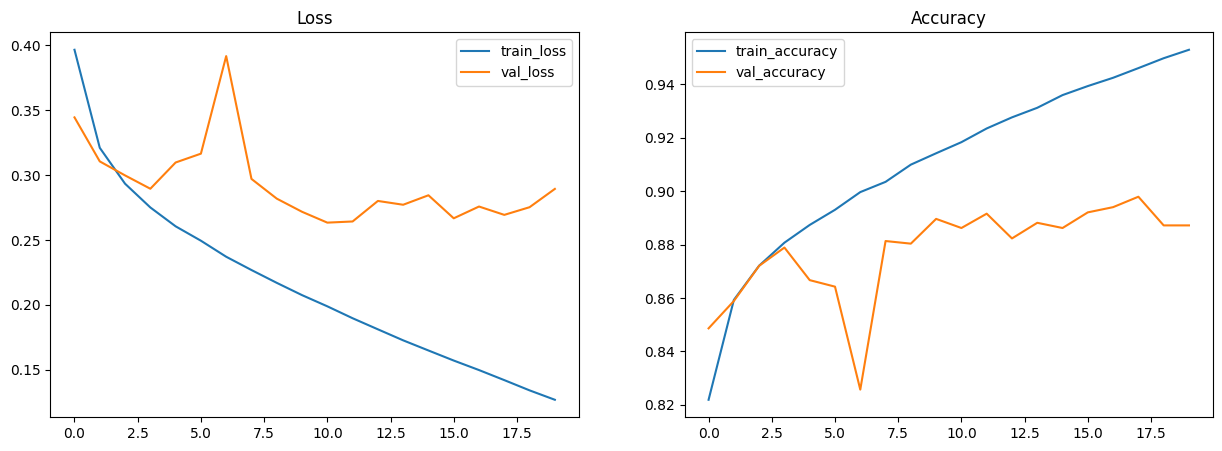

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'val'):
  ax1.plot(metrics_log[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_log[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

In [61]:
state = jax.device_get(state)

In [65]:
trained_model = nnx.merge(state.graphdef, state.params)

In [66]:
cifar2_loader = torch.utils.data.DataLoader(
  cifar2, batch_size=1, shuffle=True, collate_fn=jnp_collate)

cifar2_loader_iter = iter(cifar2_loader)
img, label = next(cifar2_loader_iter)

In [68]:
trained_model(img), label

(Array([[-3.283863 ,  3.0100281]], dtype=float32), Array([1], dtype=int32))

In [82]:
@jax.jit
def train_step(state: nnx.TrainState, batch):
  imgs, labels = batch

  def loss_fn(params):
    model = nnx.merge(state.graphdef, params)
    logits = model(imgs)
    loss1 = optax.losses.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    # L2 norm
    l2_lambda = 0.001
    loss2 = jnp.sum(
      jnp.array([jnp.sum(param**2) for param in jax.tree.leaves(params)]))
    loss = loss1 + l2_lambda*loss2
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return state, loss, accuracy

In [83]:
class NetDropout(nnx.Module):
  def __init__(self, *, n_chans1=32, deterministic: bool, rngs: nnx.Rngs):
    self.conv1 = nnx.Conv(3, n_chans1, kernel_size=(3, 3), rngs=rngs)
    self.conv1_dropout = nnx.Dropout(rate=0.4, deterministic=deterministic, rngs=rngs)
    self.conv2 = nnx.Conv(n_chans1, n_chans1//2, kernel_size=(3, 3), rngs=rngs)
    self.conv2_dropout = nnx.Dropout(rate=0.4, deterministic=deterministic, rngs=rngs)
    self.max_pool = partial(nnx.max_pool, window_shape=(2, 2), strides=(2, 2))
    self.fc1 = nnx.Linear(8*8*n_chans1//2, 32, rngs=rngs)
    self.fc2 = nnx.Linear(32, 2, rngs=rngs)

  def __call__(self, x):
    x = self.max_pool(nnx.tanh(self.conv1(x)))
    x = self.conv1_dropout(x)
    x = self.max_pool(nnx.tanh(self.conv2(x)))
    x = self.conv2_dropout(x)
    x = x.reshape(x.shape[0], -1)  # flatten
    x = nnx.tanh(self.fc1(x))
    x = self.fc2(x)
    return x

In [84]:
# train
model = NetDropout(deterministic=False, rngs=nnx.Rngs(0))

In [ ]:
# eval
model = NetDropout(deterministic=True, rngs=nnx.Rngs(0))

In [ ]:
class NetBatchNorm(nnx.Module):
  def __init__(self, *, n_chans1=32, use_running_average: bool, rngs: nnx.Rngs):
    self.conv1 = nnx.Conv(3, n_chans1, kernel_size=(3, 3), rngs=rngs)
    self.conv1_batchnorm = nnx.BatchNorm(
      num_features=n_chans1, use_running_average=use_running_average, rngs=nnx.Rngs(0))
    self.conv2 = nnx.Conv(n_chans1, n_chans1//2, kernel_size=(3, 3), rngs=rngs)
    self.conv2_batchnorm = nnx.BatchNorm(
      num_features=n_chans1//2, use_running_average=use_running_average, rngs=nnx.Rngs(0))
    self.max_pool = partial(nnx.max_pool, window_shape=(2, 2), strides=(2, 2))
    self.fc1 = nnx.Linear(8*8*n_chans1//2, 32, rngs=rngs)
    self.fc2 = nnx.Linear(32, 2, rngs=rngs)

  def __call__(self, x):
    x = self.max_pool(nnx.tanh(self.conv1_batchnorm(self.conv1(x))))
    x = self.max_pool(nnx.tanh(self.conv2_batchnorm(self.conv2(x))))
    x = x.reshape(x.shape[0], -1)  # flatten
    x = nnx.tanh(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
# train
model = NetBatchNorm(use_running_average=False, rngs=nnx.Rngs(0))

In [ ]:
# eval
model = NetBatchNorm(use_running_average=True, rngs=nnx.Rngs(0))

In [ ]:
class NetRes(nnx.Module):
  def __init__(self, *, n_chans1=32, rngs: nnx.Rngs):
    self.conv1 = nnx.Conv(3, n_chans1, kernel_size=(3, 3), rngs=rngs)
    self.conv2 = nnx.Conv(n_chans1, n_chans1//2, kernel_size=(3, 3), rngs=rngs)
    self.conv2 = nnx.Conv(n_chans1//2, n_chans1//2, kernel_size=(3, 3), rngs=rngs)
    self.max_pool = partial(nnx.max_pool, window_shape=(2, 2), strides=(2, 2))
    self.fc1 = nnx.Linear(4*4*n_chans1//2, 32, rngs=rngs)
    self.fc2 = nnx.Linear(32, 2, rngs=rngs)

  def __call__(self, x):
    x = self.max_pool(nnx.relu(self.conv1(x)))
    x = self.max_pool(nnx.relu(self.conv2(x)))
    x1 = x
    x = self.max_pool(nnx.relu(self.conv3(x)) + x1)
    x = x.reshape(x.shape[0], -1)  # flatten
    x = nnx.relu(self.fc1(x))
    x = self.fc2(x)
    return x